# OverWatch - Model Building

### This note book contains EDA, Modelling, Model selection and Conclusion

## Import libraries

In [1]:
import requests as requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import regex as re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
%matplotlib inline

## Load final csv

In [2]:
data=pd.read_csv('final_table.csv')

In [3]:
data.head()

,name,author,title,selftext,subreddit
0,t3_dl75tg,Yeledkafot,miserable with my life losing my mind,my mom got diagnosed with bipolar disease and ...,0
1,t3_dlompu,lavender-slushie,fucccck you x vent,every single fucking time i try to talk to my ...,0
2,t3_dkfrvy,TheREAL_VeraPeterson,i m so scared,i don t think i can keep going i ll begging f...,1
3,t3_dlqv8z,nearlytherezopiclone,conversation away from organising and actionin...,year old male major depressive since y...,1
4,t3_dlbxd2,flyawaythrowaway1234,self harm tw,i have razor blades and i use them to slice my...,0


# 1. Feature selection

$$\text{Baseline score}={\frac{Number of category 1 posts}{Number of category 0 posts + Number of category 1 posts}}$$

In [4]:
data['subreddit'].value_counts()

1    960
0    960
Name: subreddit, dtype: int64

In [5]:
930/(930+930)

0.5

<font color=blue>Category 1 and 0 has equal number of rows</font>
### Baseline score is 0.5


In [40]:
#Function to get GridCV scores of Naive Bayes,Logistic Regression,KNeighbors classifiers 
#with Count Vectorizer and Tfidf Vectorizer.
# Inputs:
#   X_train,X_test,y_train,y_test
#   params={'vect__analyzer': ['word'],..
#           'model__fit_prior': [True, False],..}
#   vect= 'CVT' - for Count Vectorizer
#         'TFIDF' - for Tfidf Vectorizer
#   estm= 'MNB' - for Naive Bayes
#         'LR' - for Logistic Regression
#         'KNN' - for KNeighbors
#
X_train,X_test,y_train,y_test,params,vect,estm,rocplot=[0,0,0,0,0,0,0,0]
def Models_func(X_train=X_train,
                      X_test=X_test,
                      y_train=y_train,
                      y_test=y_test,
                      params={},
                      vect='CVT',
                      estm='MNB',
                rocplot=False):
    
    if vect=='CVT' and estm=='MNB': #pipline and GridSearchCV for Naive Bayes and Count Vectorizer
        model_name='    Naive Bayes and Count Vectorizer'
        pipeline = Pipeline([('vect', CountVectorizer()),('model',MultinomialNB())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    elif vect=='TFIDF' and estm=='MNB': #pipline and GridSearchCV Naive Bayes and Tfidf Vectorizer
        model_name='    Naive Bayes and Tfidf Vectorizer'
        pipeline = Pipeline([('vect', TfidfVectorizer()),('model',MultinomialNB())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    elif vect=='CVT' and estm=='LR': #pipline and GridSearchCV Logistic Regression and Count Vectorizer
        model_name='    Logistic Regression and Count Vectorizer'
        pipeline = Pipeline([('vect', CountVectorizer()),('model',LogisticRegression())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    elif vect=='TFIDF' and estm=='LR': #pipline and GridSearchCV Logistic Regression and Tfidf Vectorizer
        model_name='    Logistic Regression and Tfidf Vectorizer'
        pipeline = Pipeline([('vect', TfidfVectorizer()),('model',LogisticRegression())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    elif vect=='CVT' and estm=='KNN': #pipline and GridSearchCV KNeighbors Classifier and Count Vectorizer
        model_name='    KNeighbors Classifier and Count Vectorizer'
        pipeline = Pipeline([('vect', CountVectorizer()),('model',KNeighborsClassifier())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    elif vect=='TFIDF' and estm=='KNN': #pipline and GridSearchCV KNeighbors Classifier and Tfidf Vectorizer
        model_name='    KNeighbors Classifier and Tfidf Vectorizer'
        pipeline = Pipeline([('vect', TfidfVectorizer()),('model',KNeighborsClassifier())])
        grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params)
        
    print('################################################')
    print('  {}'.format(model_name))
    print('################################################')
        
    grid.fit(X_train, y_train) #fit to GridSearchCV 
    best_param=grid.best_estimator_.get_params()
    print('')
    print('Best parameters of vectoriser and classifier from GridSearchCV')
    print('-----------------------------------------------------------')
    print('')
    for param_name in sorted(params.keys()):
        print('%s: %r'%(param_name,best_param[param_name]))
    predict=grid.predict(X_test)
    score_train=grid.score(X_train, y_train)
    # Score our model on the testing set.
    score_test=grid.score(X_test, y_test)
    # Generate a confusion matrix.
    cm=confusion_matrix(y_test, predict)
    cm_df = pd.DataFrame(cm, index=['Actual Depressed', 'Actual SuicideWatch'], 
                         columns=['Predicted Depressed', 'Predicted SuicideWatch'])
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    cr=classification_report(y_test,predict)
    accu = round(accuracy_score(y_test,predict)*100,2)
    Score_view(score_train,score_test,cm_df,tn,fp,fn,tp,cr,accu)
    probabilities = grid.predict_proba(X_test)
    if rocplot==True:
        roc(probabilities, y_test)

In [41]:
#function to print scores
#Inputs:
    # score_train - train score
    # score_test -test score
    # cm_df - confusion matrix dataframe
    # tn - true negative value
    # fp - false positive value
    # fn - false negative value
    # tp - true positive value
    # cr - classification report value
    # accu - accuracy value
score_train,score_test,cm_df,tn,fp,fn,tp,cr,accu=[0,0,0,0,0,0,0,0,0]
def Score_view(score_train=score_train,score_test=score_test,cm_df=cm_df,tn=tn,fp=fp,fn=fn,tp=tp,cr=cr,accu=accu):
    print("")
    print('Score our model on the training set: ',score_train)
    print("")
    print('Score our model on the testing set: ',score_test)
    print('')
    print('** Confusion matrix **')
    print('----------------------')
    print(cm_df)
    print('')
    print("True Positives: %s" % tp)
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print('')
    print(cr)
    print('')
    print('---------------------')
    print('| Accuracy : {}% |'.format(accu))
    print('---------------------')
    print('')
    print('===========================================================================')
    print('')
    print('')

In [42]:
#Function plot ROC curve and distribution of outcome histogram
def roc(probas, true):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    pred_proba = [i[1] for i in probas]
    pred_df = pd.DataFrame({'true_values': true, 'pred_probs':pred_proba})
    # Create figure.
    #plt.figure(figsize = (10,7))
    #fig, ax = 
    fig, (ax1, ax2)  = plt.subplots(1, 2,figsize=(20,7))
    #plt.subplots(figsize=(20,7))
    # Create two histograms of observations.
    ax1.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],bins=25,color='b',alpha = 0.6,label='Outcome = 0')
    ax1.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],bins=25,color='orange',alpha = 0.6,label='Outcome = 1')

    # Add vertical line at P(Outcome = 1) = 0.5.
    ax1.vlines(x=0.5,ymin = 0,ymax = 65,color='r',linestyle = '--')

    # Label axes.
    ax1.set_title('Distribution of P(Outcome = 1)', fontsize=22)
    ax1.set_ylabel('Frequency', fontsize=18)
    ax1.set_xlabel('Predicted Probability that Outcome = 1', fontsize=18)

    # Create legend.
    #plt.legend(fontsize=20);
    step=0.001
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

## 1.1. Title as feature using Count Vectoriser

#### Select x and y and split data into training and testing sets. Explore gridsearchCV best parameters best scores and accuracy of 'Title' feature between Naive Bayes with Count Vectorizer and Naive Bayes and Tfidf Vectorizer

In [44]:
X=data['title']
y=data['subreddit']
X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__analyzer': ['word'],
        'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__alpha': np.linspace(0.5, 1.5, 6),
        'model__fit_prior': [True, False]}

#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'MNB' - for Naive Bayes
estm='MNB'
vect='CVT'
Models_func(X_title_train, X_title_test, y_title_train, y_title_test,params,vect,estm)

vect='TFIDF'
Models_func(X_title_train, X_title_test, y_title_train, y_title_test,params,vect,estm)

################################################
      Naive Bayes and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__alpha: 0.5
model__fit_prior: True
vect__analyzer: 'word'
vect__max_features: 200
vect__ngram_range: (1, 1)

Score our model on the training set:  0.6852678571428571

Score our model on the testing set:  0.5711805555555556

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     172                     116
Actual SuicideWatch                  131                     157

True Positives: 157
True Negatives: 172
False Positives: 116
False Negatives: 131

              precision    recall  f1-score   support

           0       0.57      0.60      0.58       288
           1       0.58      0.55      0.56       288

    accuracy       

<font color=blue>Both models are over fitted the variance between train and test score is wide. and performed worst in accuracy.   
    Using 'title' as feature and Count vectorizer able to achive <b>**57.12%**</b> accuracy.   
Predicted SuicideWatch category posts are 157 from total of 288 actual posts.   
Total of 247 were misclassified.</font>


## 1.2. Selftext as feature

#### Select x and y and split data into training and testing sets. Explore gridsearchCV best parameters best scores and accuracy of 'Selftext' feature between Naive Bayes with Count Vectorizer and Naive Bayes and Tfidf Vectorizer

In [9]:
X=data['selftext']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__analyzer': ['word'],
        'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__alpha': np.linspace(0.5, 1.5, 6),
        'model__fit_prior': [True, False]}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'MNB' - for Naive Bayes
estm='MNB'
vect='CVT'
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

################################################
      Naive Bayes and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__alpha: 0.9
model__fit_prior: True
vect__analyzer: 'word'
vect__max_features: 1000
vect__ngram_range: (1, 1)

Score our model on the training set:  0.7805059523809523

Score our model on the testing set:  0.6822916666666666

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     212                      76
Actual SuicideWatch                  107                     181

True Positives: 181
True Negatives: 212
False Positives: 76
False Negatives: 107

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       288
           1       0.70      0.63      0.66       288

    accuracy       

<font color=blue>Using 'selftext' as feature and Tfidf Vectorizer able to achive <b>72.22%</b> accuracy.  
Predicted SuicideWatch category posts are 201 out of 288.   
Total of 160 were misclassified to wrong categories.  
Although accuracy is better than 'title' as feature, still both models are overfitted.  Decided to improve futher by exploring other NLP models using 'selftext' as feature.</font>

# 2. EDA

In [10]:
# get frequency of the words in selftext column
word_freq=pd.DataFrame(data['selftext'].str.split(expand=True).stack().value_counts()).head(25)
word_freq.columns=['Word Count']
word_freq.head(10)

,Word Count
i,27574
to,12630
and,11332
the,7678
my,7526
a,6834
it,5923
t,5232
me,5030
of,5008


In [11]:
#Apply nltk.corpus stop words to selftext
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['selftext'] = data['selftext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

<font color=blue> Stop word are used to ingore most commonly used words in the post as they would not comtribute to the models and to deduce features and over fitting</font>

In [12]:
#Function to bar plot to 25 words in the given dataframe column
def word_freq(df,title_text='',x_label='',y_label=''):
    word_freq=pd.DataFrame(df.str.split(expand=True).stack().value_counts()).head(25)
    word_freq.columns=['Word Count']
    fig, ax = plt.subplots(figsize=(20,7))
    sns.barplot(x=word_freq.index,y=word_freq['Word Count'],ax=ax);
    ax.set_xlabel(x_label,fontsize=20)
    ax.set_ylabel(y_label,fontsize=20)
    ax.set_title(title_text,fontsize=30)
    

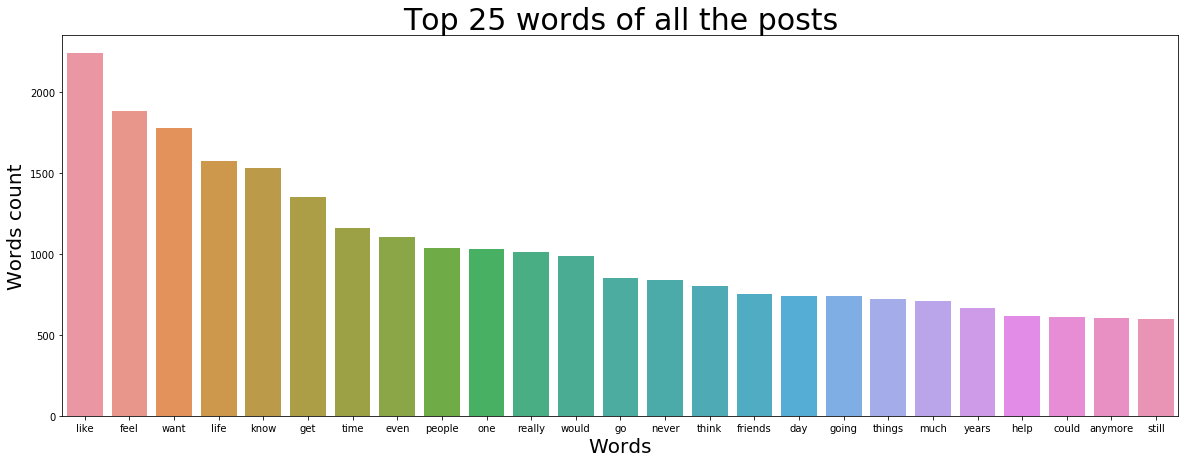

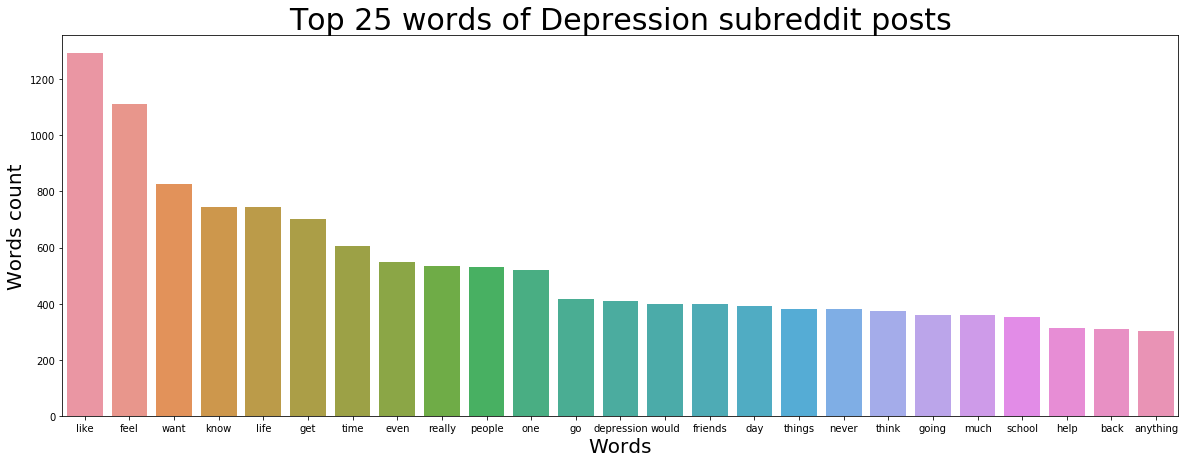

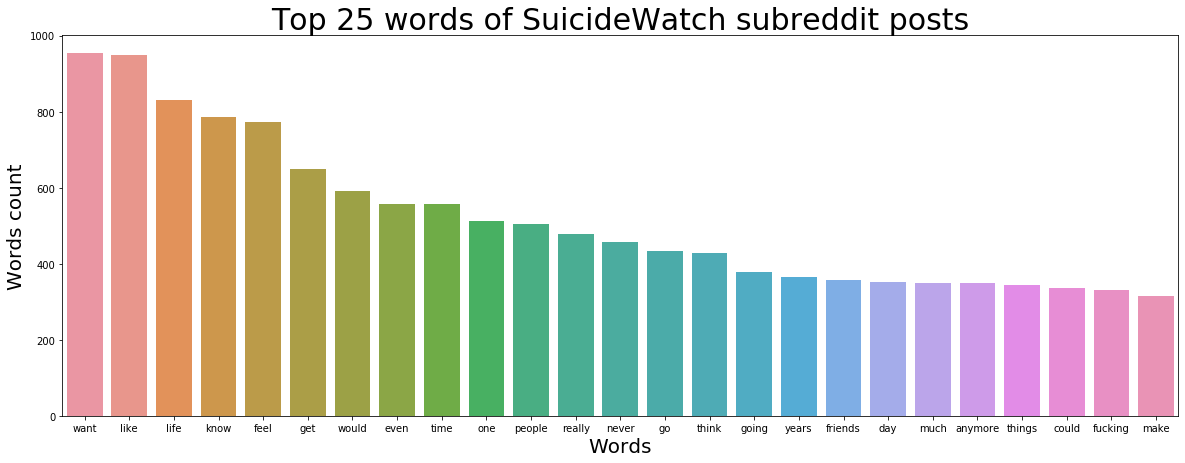

In [13]:
word_freq(data['selftext'],title_text='Top 25 words of all the posts',x_label='Words',y_label='Words count')
tempdf=pd.DataFrame(data['selftext'][data['subreddit'] == 0])
word_freq(tempdf['selftext'],title_text='Top 25 words of Depression subreddit posts',x_label='Words',y_label='Words count')
tempdf=pd.DataFrame(data['selftext'][data['subreddit'] == 1])
word_freq(tempdf['selftext'],title_text='Top 25 words of SuicideWatch subreddit posts',x_label='Words',y_label='Words count')

<font color=blue>In 20 top words for the Depression posts and SuicideWatch posts have many common words.  
In future any or all of these words may need to be dropped to improve accuracy.</font>

### Lemmatization and Stemming 'selftext'

**Lemmatization and Stemming a technique of text normalization and making the words to useful core meaning.**

In [14]:
#lemmatize selftext to new column 'selftext_lemma'
def lemmatize(selftext):
    lemmatizer = nltk.WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(selftext)]

data['selftext_lemma'] = data.selftext.apply(lemmatize)
data['selftext_lemma']= data['selftext_lemma'].str.join(' ')

**Lemmatization**  
<font color=blue> Lemmatization usually refers to the morphological analysis of words, which aims to remove inflectional endings. It helps in returning the base or dictionary form of a word, which is known as the lemma. </font>

In [15]:
#compare lemmatised and original selftext
data['selftext_lemma'].head()

0    mom got diagnosed bipolar disease schizophreni...
1    every single fucking time try talk boyfriend b...
2    think keep going begging reason stay got nothi...
3    year old male major depressive since year old ...
4    razor blade use slice body open punish upsetti...
Name: selftext_lemma, dtype: object

In [16]:
data['selftext'].head()

0    mom got diagnosed bipolar disease schizophreni...
1    every single fucking time try talk boyfriend b...
2    think keep going begging reason stay got nothi...
3    year old male major depressive since years old...
4    razor blades use slice body open punish upsett...
Name: selftext, dtype: object

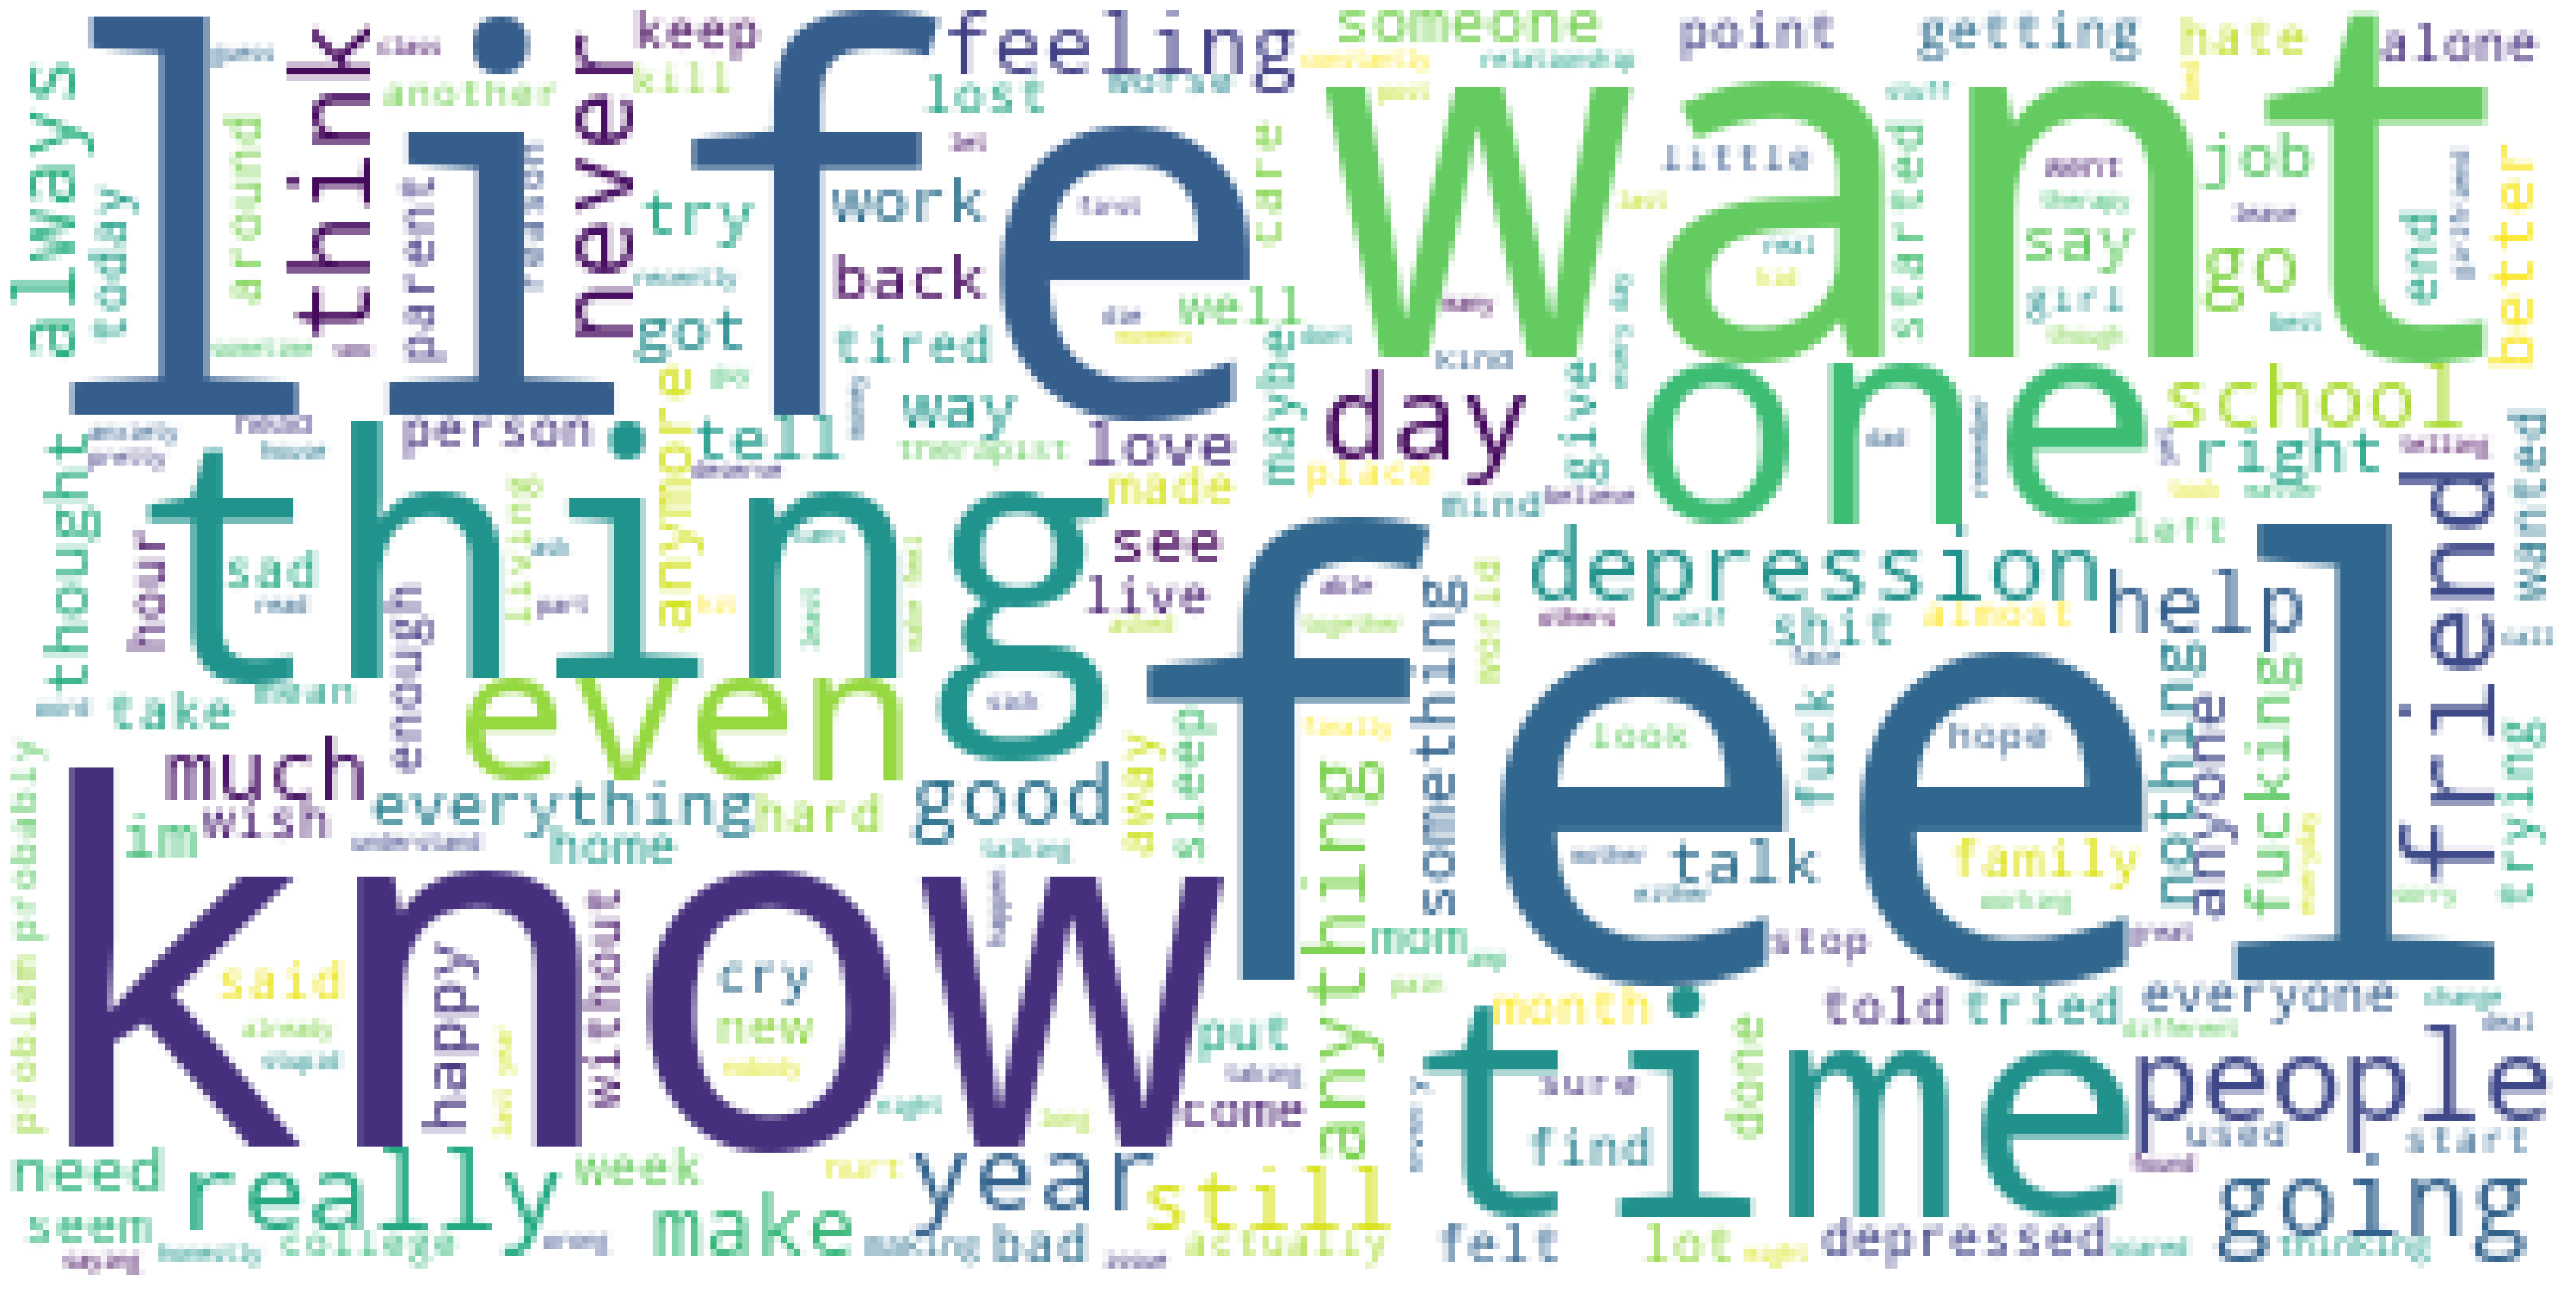

In [17]:
#Wordcloud visualisation
wordcloud2 = WordCloud(max_words=1000,background_color='white').generate(' '.join(data['selftext_lemma'][data['subreddit'] == 0]))
plt.figure(figsize=(75,75))
plt.imshow(wordcloud2, interpolation='nearest')
plt.axis("off")
plt.show()

<font color=blue>Word Cloud of lemmatized words size, size of the words in the above plot determined by the frequency of the word</font>

In [18]:
#Stemming selftext to new column 'selftext_stem'
def Stemming(selftext):
    stemming = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [stemming.stem(w) for w in tokenizer.tokenize(selftext)]

data['selftext_stem'] = data.selftext.apply(Stemming)
data['selftext_stem']= data['selftext_stem'].str.join(' ')

**Stemming**  
<font color=blue>Stemming is a word normalization technique. Normalization is a technique where a set of words in a sentence are converted into a sequence to shorten its lookup.</font>

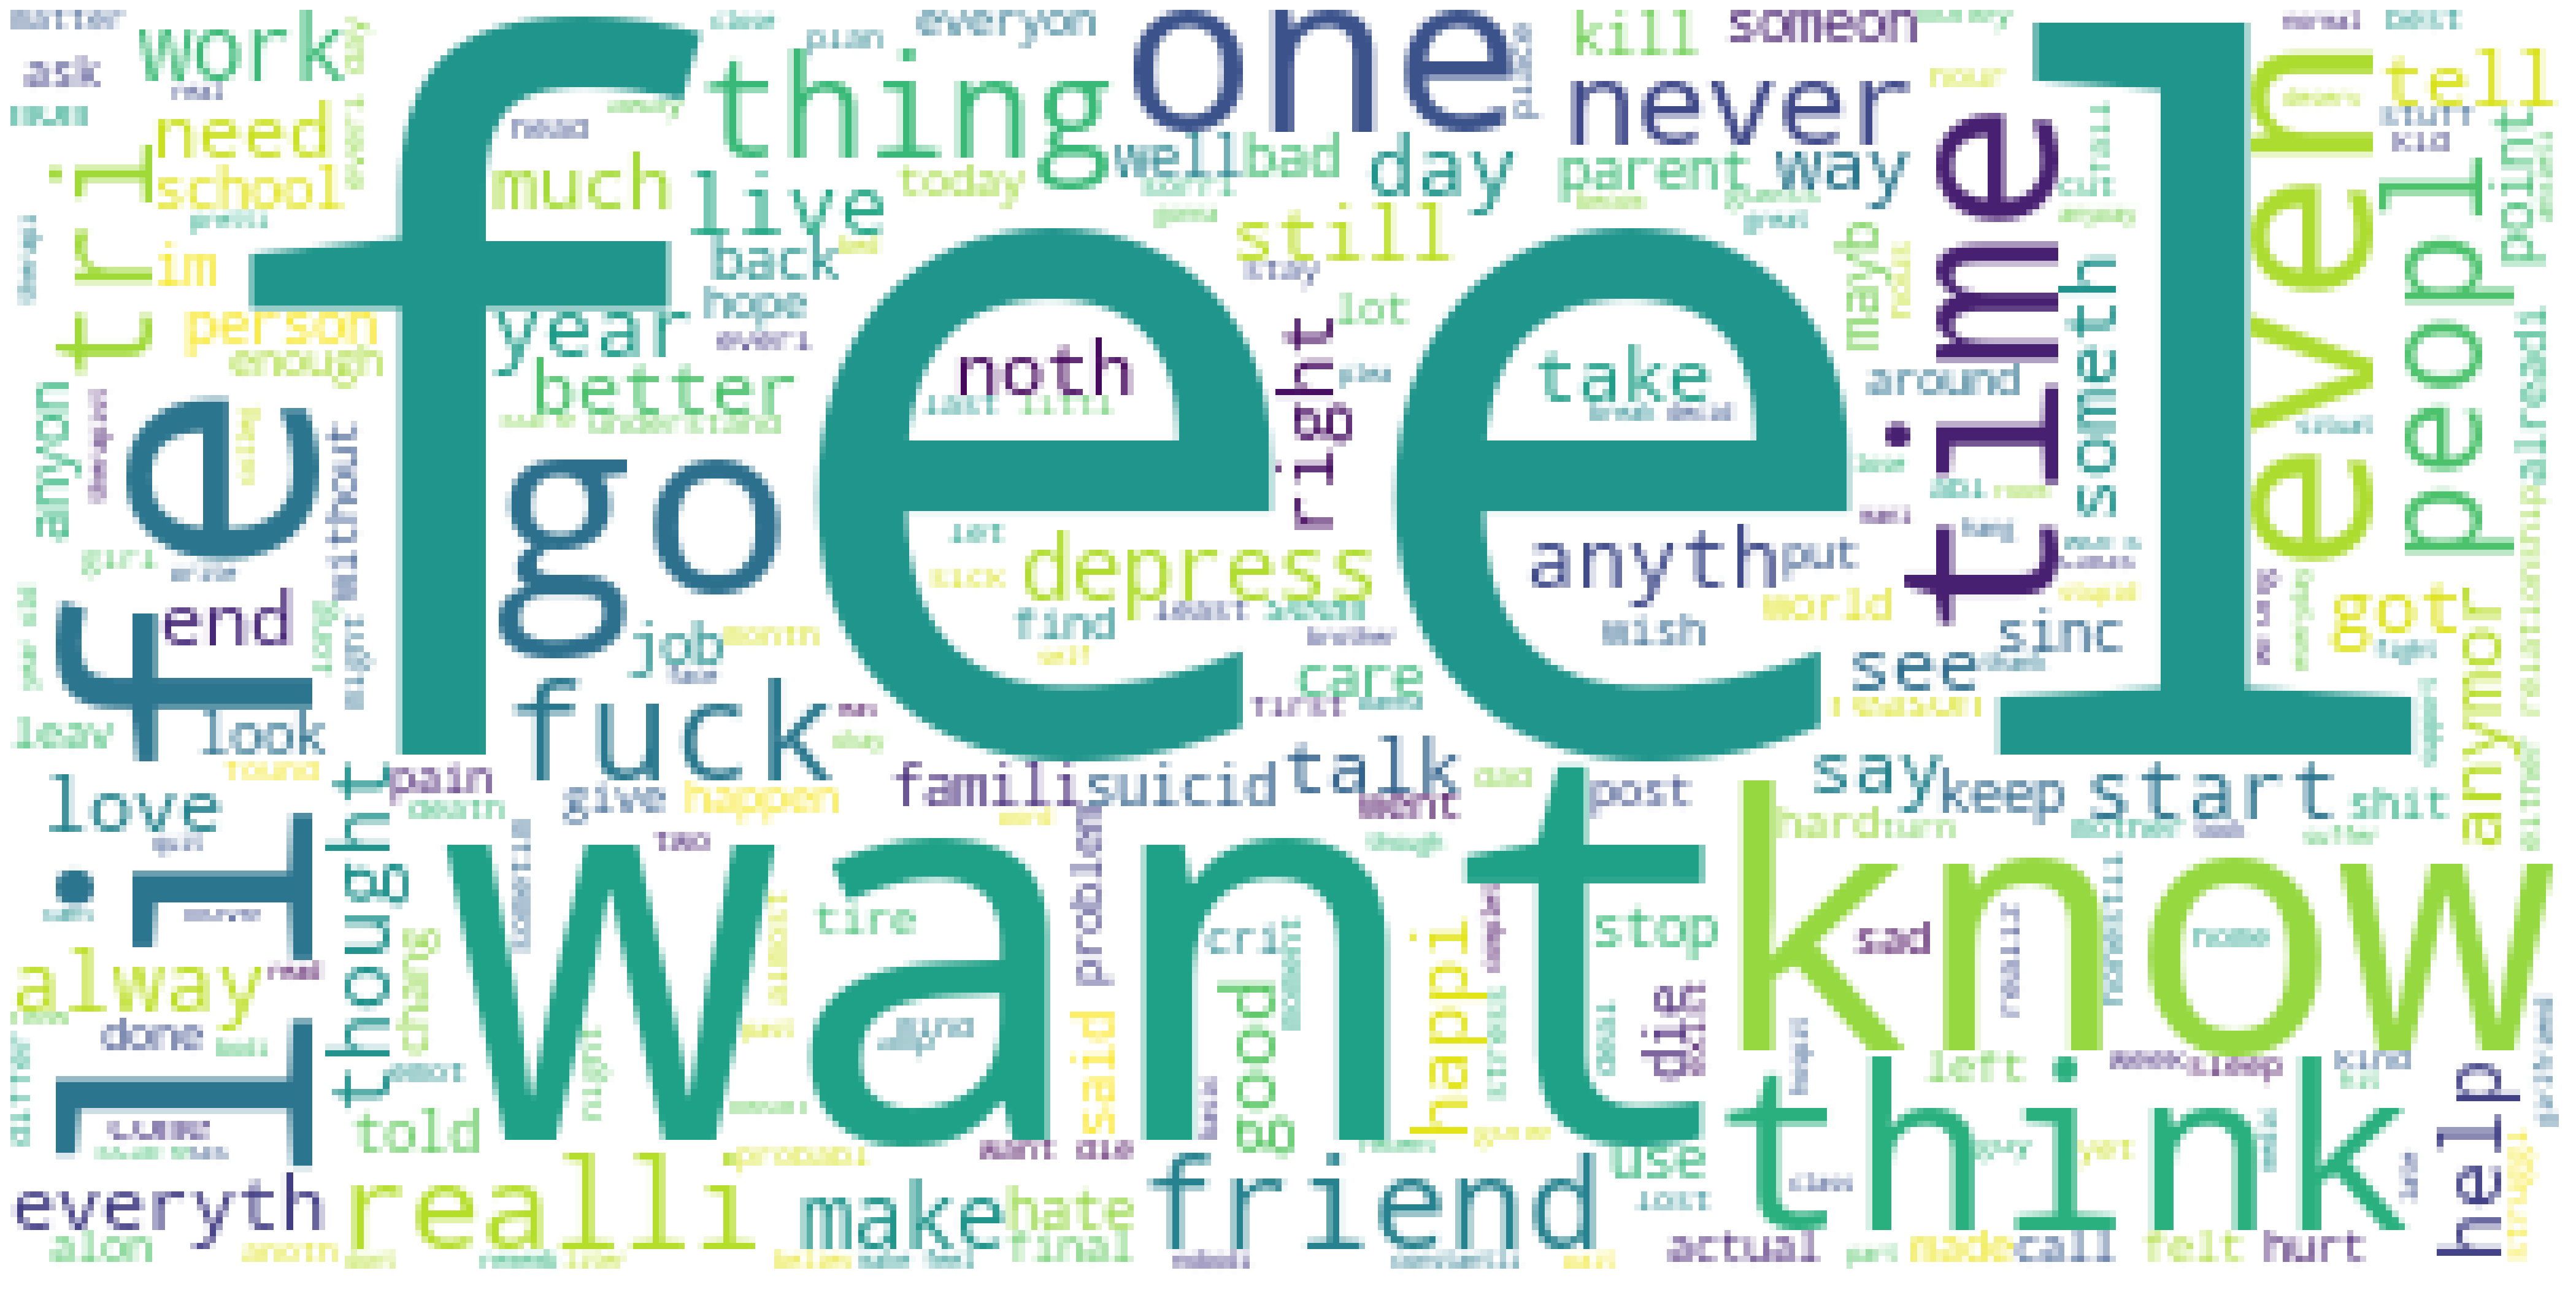

In [19]:
#Wordcloud visualisation
wordcloud2 = WordCloud(max_words=1000,background_color='white',max_font_size=150).generate(' '.join(data['selftext_stem']))
plt.figure(figsize=(75,75))
plt.imshow(wordcloud2, interpolation='nearest')
plt.axis("off")
plt.show()

<font color=blue>Word Cloud of stemmed words size, size of the words in the above plot determined by the frequency of the word</font>

In [20]:
data['selftext_stem'].head()

0    mom got diagnos bipolar diseas schizophrenia d...
1    everi singl fuck time tri talk boyfriend bothe...
2    think keep go beg reason stay got noth post pa...
3    year old male major depress sinc year old suic...
4    razor blade use slice bodi open punish upset p...
Name: selftext_stem, dtype: object

In [21]:
#spacy selftext to new column 'selftext_spacy'
import spacy
nlp = spacy.load("en")
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

data['selftext_spacy'] =  data.apply(lambda x: lemmatizer(x['selftext']), axis=1)
data['selftext_spacy'] = data['selftext_spacy'].replace(to_replace=r'-PRON-', value=' ', regex=True)

**spaCy:**  
<font color=blue>The spaCy library is one of the most popular NLP libraries along with NLTK. The basic difference between the two libraries is the fact that NLTK contains a wide variety of algorithms to solve one problem whereas spaCy contains only one, but the best algorithm to solve a problem.<font>

In [22]:
#remove 'http www reddit com' from all new columns
data['selftext_lemma'] = data['selftext_lemma'].replace(to_replace=r'http www reddit com', value=' ', regex=True)
data['selftext_stem'] = data['selftext_stem'].replace(to_replace=r'http www reddit com', value=' ', regex=True)
data['selftext_spacy'] = data['selftext_spacy'].replace(to_replace=r'http www reddit com', value=' ', regex=True)
print(data[data['selftext_lemma'].str.contains("http www reddit com")])
print(data[data['selftext_stem'].str.contains("http www reddit com")])
print(data[data['selftext_spacy'].str.contains("http www reddit com")])

Empty DataFrame
Columns: [name, author, title, selftext, subreddit, selftext_lemma, selftext_stem, selftext_spacy]
Index: []
Empty DataFrame
Columns: [name, author, title, selftext, subreddit, selftext_lemma, selftext_stem, selftext_spacy]
Index: []
Empty DataFrame
Columns: [name, author, title, selftext, subreddit, selftext_lemma, selftext_stem, selftext_spacy]
Index: []


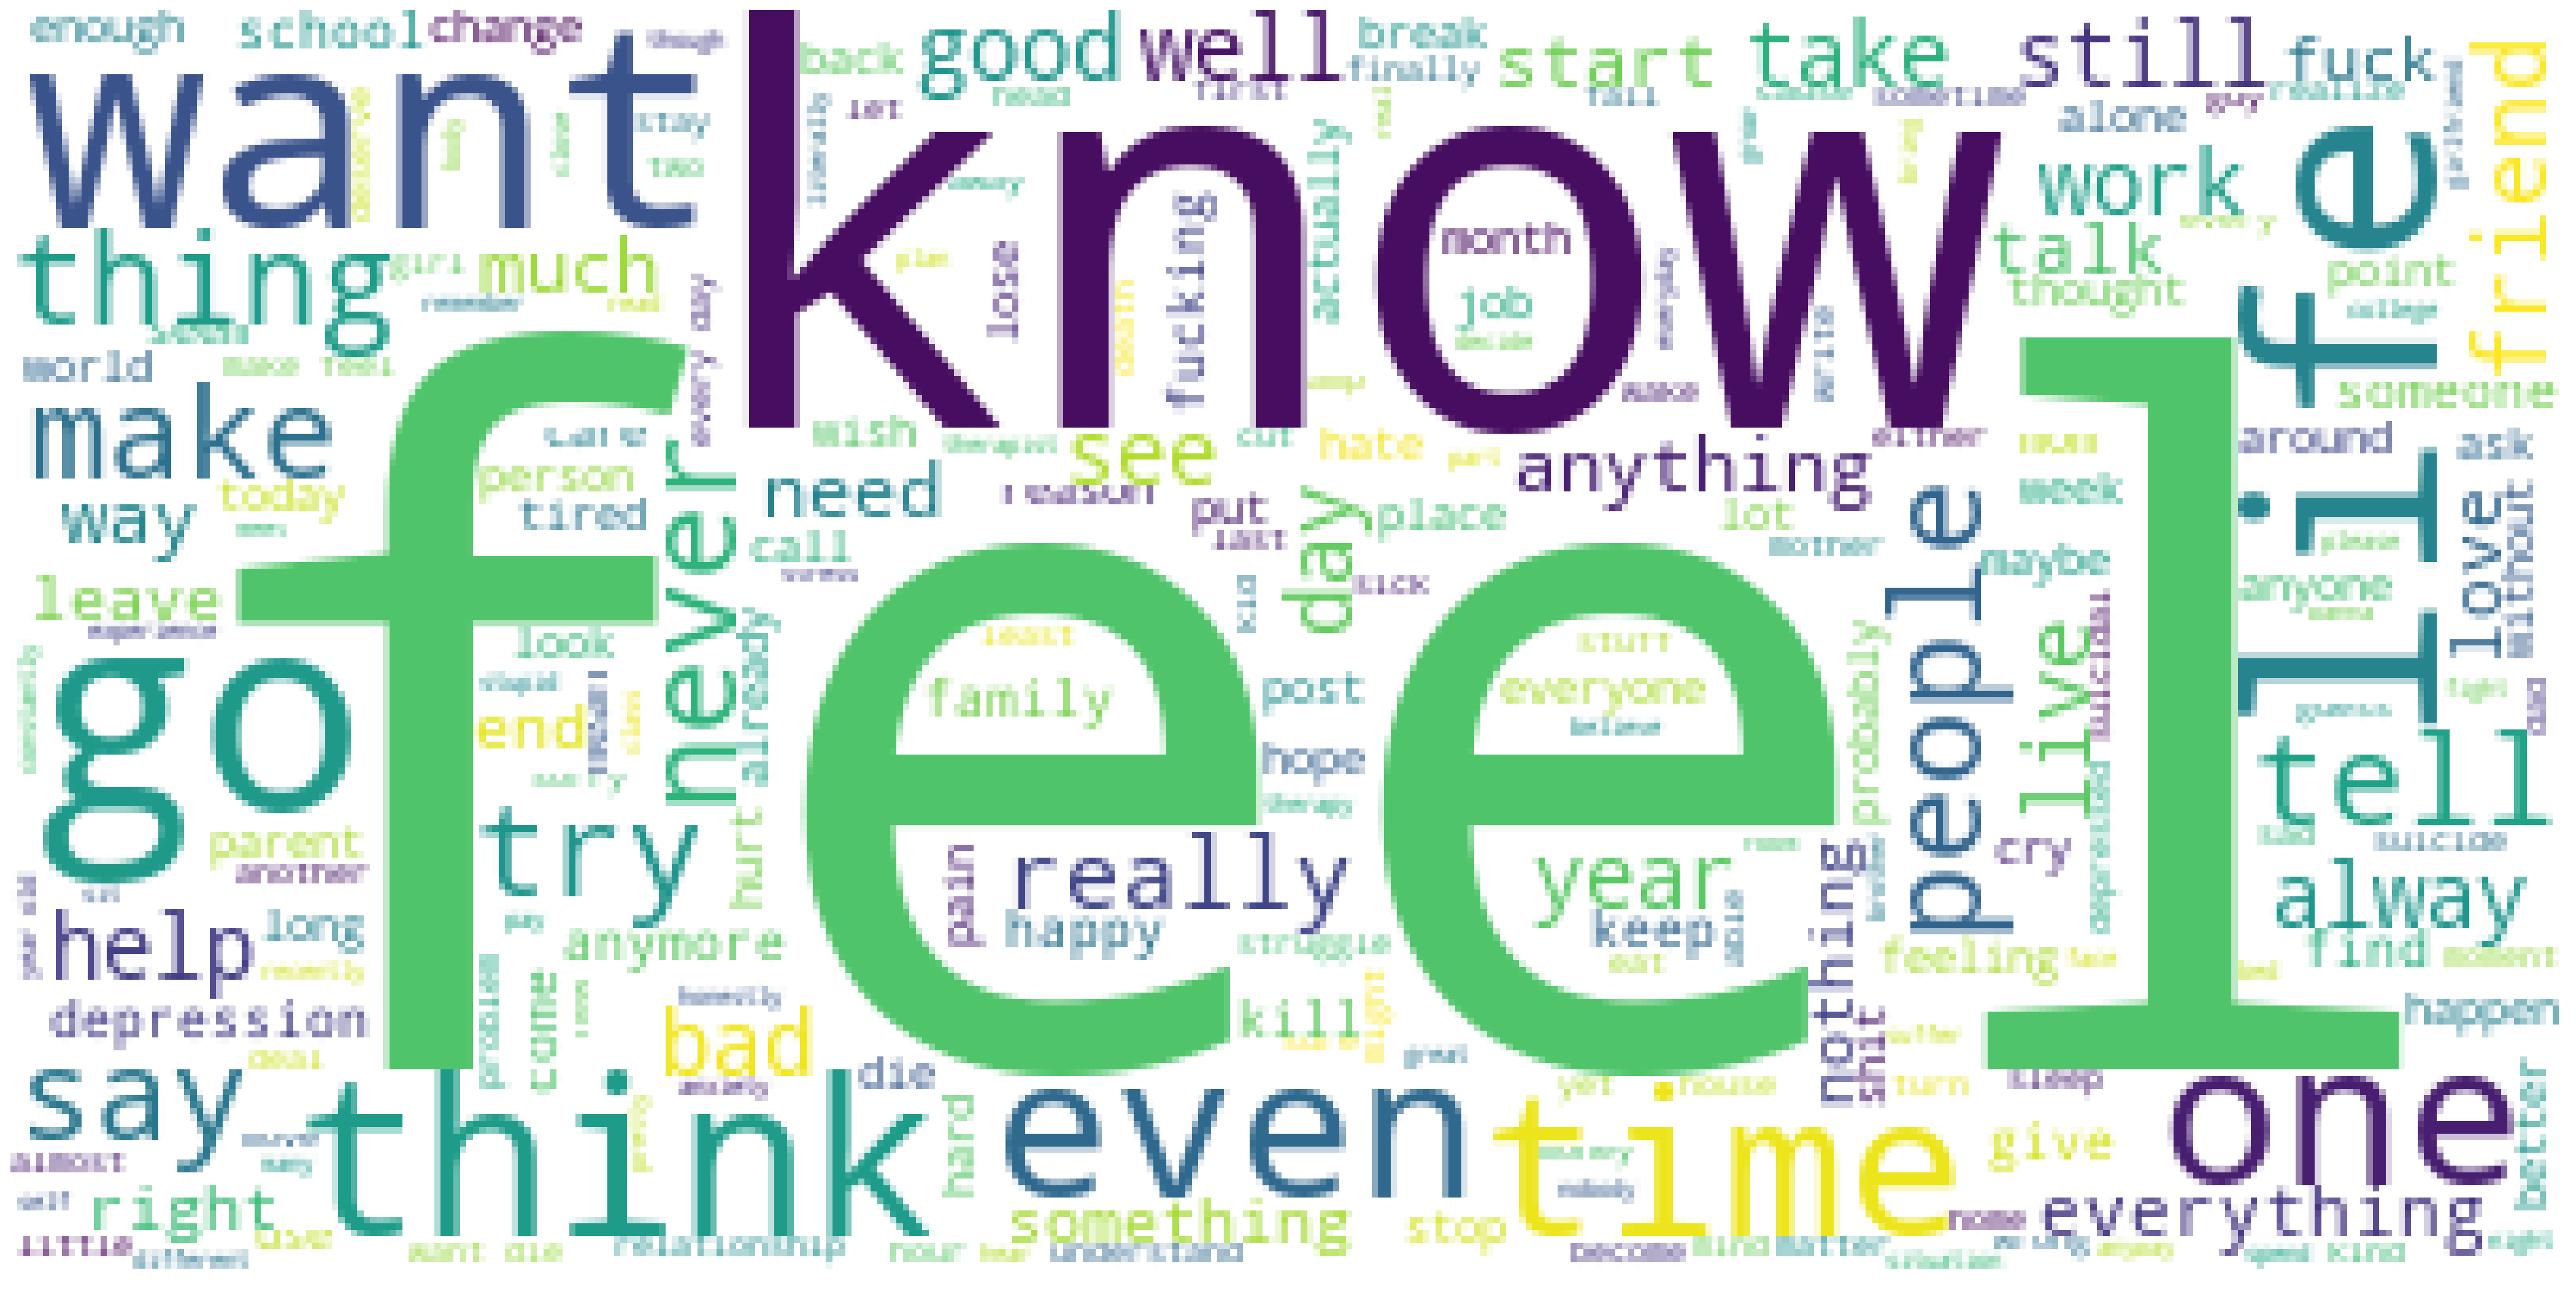

In [23]:
#Wordcloud visualisation
wordcloud2 = WordCloud(max_words=1000,background_color='white',max_font_size=150).generate(' '.join(data['selftext_spacy']))
plt.figure(figsize=(75,75))
plt.imshow(wordcloud2, interpolation='nearest')

plt.axis("off")
plt.show()

<font color=blue>Word Cloud of spaCy lemmatized words size, size of the words in the above plot determined by the frequency of the word</font>

# 3. Model Selection

In this section will do modelling and get parameters using Grid Search in Logistic Regression and K Nearest Neighbor(KNN) classifiers with different vectorizers and word normalizers. Model matix can be seen in the tables below.  

|Logistic Regression|||
|--|--|--|
||Count Vectorizer|Tfidf Vectorizer|
|Original text|LR Model 1|LR Model 2|
|Lemmatizing|LR Model 3|LR Model 4|
|Stemming|LR Model 5|LR Model 6|
|spaCy|LR Model 7|LR Model 8|

|k-nearest neighbors (KNN)|||
|--|--|--|
||Count Vectorizer|Tfidf Vectorizer|
|Original text|KNN Model 1|KNN Model 2|
|Lemmatizing|KNN Model 3|KNN Model 4|
|Stemming|KNN Model 5|KNN Model 6|
|spaCy|KNN Model 7|KNN Model 8|

**Logistic regression** 
Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  
**k-nearest neighbors (KNN)**
The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems.  
**Grid Search**  
The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.  
**Count Vectorizer**  
The most straightforward one, it counts the number of times a token shows up in the document and uses this value as its weight.  
**Tfidf Vectorizer**  
weight assigned to each token not only depends on its frequency in a document but also how recurrent that term is in the entire corpus.

## 3.1. Logistic Regression model selection

### 3.1.1. Logistic Regression models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts without any lemmatizing

In [24]:
X=data['selftext']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__C':[0.01,1,10,100,1000],
        'model__penalty':['l1','l2'],
    'model__solver':['liblinear','saga']}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'LR' - for Logistic Regression
estm='LR'
vect='CVT'
print('** LR Model 1 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** LR Model 2 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** LR Model 1 **
################################################
      Logistic Regression and Count Vectorizer
################################################


/Users/rt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__C: 0.01
model__penalty: 'l2'
model__solver: 'saga'
vect__max_features: 2000
vect__ngram_range: (1, 2)

Score our model on the training set:  0.8162202380952381

Score our model on the testing set:  0.7013888888888888

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     205                      83
Actual SuicideWatch                   89                     199

True Positives: 199
True Negatives: 205
False Positives: 83
False Negatives: 89

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       288
           1       0.71      0.69      0.70       288

    accuracy                           0.70       576
   macro avg       0.70      0.70      0.70       576
weighted avg       0.70      0.70      0.70       576



<font color=blue>LR Model 2 using 'selftext' as feature and Tfidf Vectorizer able to achive <b>70.49%</b> accuracy than model with Count Vectorizer. So far this is the best accuracy between Naive Bayes and Logistic regression.  
Predicted SuicideWatch category posts are 196 out of 288 actual.   
Total of 170 were misclassified.  
Although accuracy is better than other models, still both models are overfitted.  Decided to improve futher by exploring other NLP models using 'selftext' as feature with lemmatizing.</font>

### 3.1.2. Logistic Regression models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts with lemmatize

In [25]:
X=data['selftext_lemma']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__C':[0.01,1,10,100,1000],
        'model__penalty':['l1','l2'],
    'model__solver':['liblinear','saga']}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'LR' - for Logistic Regression
estm='LR'
vect='CVT'
print('** LR Model 3 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** LR Model 4 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** LR Model 3 **
################################################
      Logistic Regression and Count Vectorizer
################################################


/Users/rt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__C: 1
model__penalty: 'l2'
model__solver: 'saga'
vect__max_features: 2000
vect__ngram_range: (1, 2)

Score our model on the training set:  0.8727678571428571

Score our model on the testing set:  0.703125

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     207                      81
Actual SuicideWatch                   90                     198

True Positives: 198
True Negatives: 207
False Positives: 81
False Negatives: 90

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       288
           1       0.71      0.69      0.70       288

    accuracy                           0.70       576
   macro avg       0.70      0.70      0.70       576
weighted avg       0.70      0.70      0.70       576


------------

<font color=blue>LR Model 4 using lemmatized 'selftext' as feature and Tfidf Vectorizer able to achive <b>71 - 72.4%</b> accuracy than model with Count Vectorizer, and both train and test scores are close. So far this is the best accuracy than other models.  
Predicted SuicideWatch category posts are 206 out of 288 actual.   
Total of 159 were misclassified.  
Decided to improve futher by exploring other combination of models.</font>

### 3.1.2. Logistic Regression models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts with stemming

In [26]:
X=data['selftext_stem']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__C':[0.01,1,10,100,1000],
        'model__penalty':['l1','l2'],
    'model__solver':['liblinear','saga']}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'LR' - for Logistic Regression
estm='LR'
vect='CVT'
print('** LR Model 5 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** LR Model 6 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** LR Model 5 **
################################################
      Logistic Regression and Count Vectorizer
################################################


/Users/rt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__C: 0.01
model__penalty: 'l2'
model__solver: 'saga'
vect__max_features: 1000
vect__ngram_range: (1, 1)

Score our model on the training set:  0.8058035714285714

Score our model on the testing set:  0.7118055555555556

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     206                      82
Actual SuicideWatch                   84                     204

True Positives: 204
True Negatives: 206
False Positives: 82
False Negatives: 84

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       288
           1       0.71      0.71      0.71       288

    accuracy                           0.71       576
   macro avg       0.71      0.71      0.71       576
weighted avg       0.71      0.71      0.71       576



<font color=blue>LR Model 5 using 'selftext' with stemming as feature and Count Vectorizer has higher <b>71.18%</b> accuracy than model other model.
Predicted SuicideWatch category posts are 204 out of 288 actual.   
Total of 166 were misclassified.Still both models are overfitted. Still performed worse than LR Model 4 in terms of accuracy and fitting.</font>

### 3.1.3. Logistic Regression models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts with spacy emmatize

In [27]:
X=data['selftext_spacy']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__C':[0.01,1,10,100,1000],
        'model__penalty':['l1','l2'],
    'model__solver':['liblinear','saga']}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'LR' - for Logistic Regression
estm='LR'
vect='CVT'
print('** LR Model 7 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** LR Model 8 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** LR Model 7 **
################################################
      Logistic Regression and Count Vectorizer
################################################


/Users/rt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__C: 100
model__penalty: 'l1'
model__solver: 'saga'
vect__max_features: 2000
vect__ngram_range: (1, 2)

Score our model on the training set:  0.8459821428571429

Score our model on the testing set:  0.6770833333333334

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     200                      88
Actual SuicideWatch                   98                     190

True Positives: 190
True Negatives: 200
False Positives: 88
False Negatives: 98

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       288
           1       0.68      0.66      0.67       288

    accuracy                           0.68       576
   macro avg       0.68      0.68      0.68       576
weighted avg       0.68      0.68      0.68       576




<font color=blue>LR Model 5 using 'selftext' with spaCy as feature and Count Vectorizer has higher <b>72.05%</b>accuracy than model other model. Predicted SuicideWatch category posts are 195 out of 288 actual. Performed worse than LR Model 4.
Total of 161 were misclassified.</font>



## 4.1. KNN model selection

### 4.1.1. KNN models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts without any lemmatizing

In [28]:
X=data['selftext']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
       'model__leaf_size':[10,20,30,40],
       'model__n_neighbors':[3,5,7,9,11]}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'KNN' - for KNeighbors
estm='KNN'
vect='CVT'
print('** KNN Model 1 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** KNN Model 2 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** KNN Model 1 **
################################################
      KNeighbors Classifier and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__leaf_size: 10
model__n_neighbors: 11
vect__max_features: 200
vect__ngram_range: (1, 1)

Score our model on the training set:  0.6912202380952381

Score our model on the testing set:  0.6180555555555556

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     182                     106
Actual SuicideWatch                  114                     174

True Positives: 174
True Negatives: 182
False Positives: 106
False Negatives: 114

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       288
           1       0.62      0.60      0.61       288

    accurac

<font color=blue>KNN Model 1 using 'selftext' as feature and Count Vectorizer has higher <b>61.81%</b>accuracy than model other model KNN. Predicted SuicideWatch category posts are 174 out of 288 actual. Performed worse than LR Model 4.
Total of 243 were misclassified.</font>

### 4.1.2. KNN models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts without lemmatizing

In [29]:
X=data['selftext_lemma']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
       'model__leaf_size':[10,20,30,40],
       'model__n_neighbors':[3,5,7,9,11]}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'KNN' - for KNeighbors
estm='KNN'
vect='CVT'
print('** KNN Model 3 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** KNN Model 4 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** KNN Model 3 **
################################################
      KNeighbors Classifier and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__leaf_size: 10
model__n_neighbors: 9
vect__max_features: 100
vect__ngram_range: (1, 2)

Score our model on the training set:  0.6822916666666666

Score our model on the testing set:  0.5850694444444444

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     151                     137
Actual SuicideWatch                  102                     186

True Positives: 186
True Negatives: 151
False Positives: 137
False Negatives: 102

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       288
           1       0.58      0.65      0.61       288

    accuracy

<font color=blue>Both KNN Model 3 and 4 performed worse than other models</font>

### 4.1.3. KNN models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts without stemming

In [30]:
X=data['selftext_stem']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
       'model__leaf_size':[10,20,30,40],
       'model__n_neighbors':[3,5,7,9,11]}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'KNN' - for KNeighbors
estm='KNN'
vect='CVT'
print('** KNN Model 5 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** KNN Model 6 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** KNN Model 5 **
################################################
      KNeighbors Classifier and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__leaf_size: 10
model__n_neighbors: 7
vect__max_features: 100
vect__ngram_range: (1, 2)

Score our model on the training set:  0.7083333333333334

Score our model on the testing set:  0.5989583333333334

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     162                     126
Actual SuicideWatch                  105                     183

True Positives: 183
True Negatives: 162
False Positives: 126
False Negatives: 105

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       288
           1       0.59      0.64      0.61       288

    accuracy

<font color=blue>Both KNN Model 5 and 6 performed worse than LR Model 4</font>

### 4.1.4. KNN models with Count Vectorizer and Tfidf Vectorizer using 'selftext' posts without spacy lemmatizing

In [31]:
X=data['selftext_spacy']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
       'model__leaf_size':[10,20,30,40],
       'model__n_neighbors':[3,5,7,9,11]}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'KNN' - for KNeighbors
estm='KNN'
vect='CVT'
print('** KNN Model 7 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)
vect='TFIDF'
print('** KNN Model 8 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm)

** KNN Model 7 **
################################################
      KNeighbors Classifier and Count Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__leaf_size: 10
model__n_neighbors: 11
vect__max_features: 100
vect__ngram_range: (1, 2)

Score our model on the training set:  0.6770833333333334

Score our model on the testing set:  0.5833333333333334

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     160                     128
Actual SuicideWatch                  112                     176

True Positives: 176
True Negatives: 160
False Positives: 128
False Negatives: 112

              precision    recall  f1-score   support

           0       0.59      0.56      0.57       288
           1       0.58      0.61      0.59       288

    accurac

<font color=blue>Both KNN Model 7 and 8 performed worse than LR Model 4</font>

# Conclusion

## LR Model 4 is selected as best model from all the models tried so far

** LR Model 4 **
################################################
      Logistic Regression and Tfidf Vectorizer
################################################

Best parameters of vectoriser and classifier from GridSearchCV
-----------------------------------------------------------

model__C: 0.01
model__penalty: 'l2'
model__solver: 'saga'
vect__max_features: 2000
vect__ngram_range: (1, 1)

Score our model on the training set:  0.7916666666666666

Score our model on the testing set:  0.7204861111111112

** Confusion matrix **
----------------------
                     Predicted Depressed  Predicted SuicideWatch
Actual Depressed                     204                      84
Actual SuicideWatch                   77                     211

True Positives: 211
True Negatives: 204
False Positives: 84
False Negatives: 77

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       288
           1       0.72      0.73      0.72       288

 

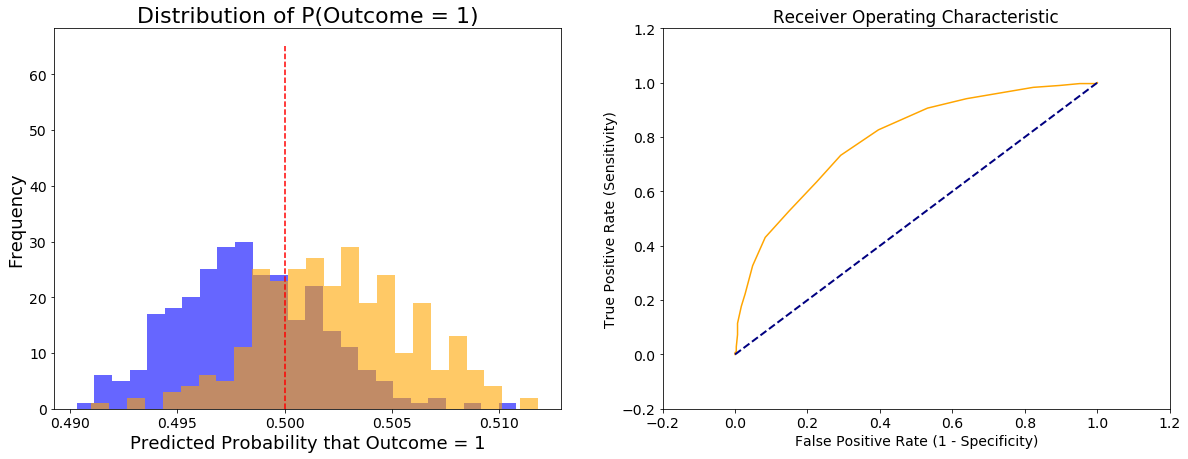

In [46]:
X=data['selftext_lemma']
y=data['subreddit']
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)
#parameter range to be searched for best parameters
params={'vect__ngram_range':[(1, 1),(1,2)],
        'vect__max_features':[1,10,100,200,1000,2000],
        'model__C':[0.01,1,10,100,1000],
        'model__penalty':['l1','l2'],
    'model__solver':['liblinear','saga']}
#'CVT' - for Count Vectorizer
#'TFIDF' - for Tfidf Vectorizer
#'LR' - for Logistic Regression
estm='LR'
vect='TFIDF'
print('** LR Model 4 **')
Models_func(X_st_train, X_st_test, y_st_train, y_st_test,params,vect,estm,rocplot=True)

In [54]:
sen=211/(211+204)
spe=204/(204+84)
print('Sensitivity: ',sen)
print('Specificity: ',spe)

Sensitivity:  0.5084337349397591
Specificity:  0.7083333333333334


<font color=blue>Final model able to classify ~ <b>72.05%</b> (AUC=~0.72) of the posts to repective categories with the threshold hold at 0.5.  
From the porbability distribution histogram plot the over lapping of plots for Depressed and SuicideWatch, observed there are Type 1 and Type 2 errors introduced.<br>
Sensitivity (True Positive Rate) is the important aspect to the problem statment, it must further improved in future.</font>

## Limitation

<font color=blue>Initial assumption of collected data is clean could be very wrong, collected data could be dirty. In the posts collected there could be some posts already misclassified by the auther. The best model could have predicted correctly but since it was already misclassified in training data set, the predicted class fell under false positive or vise versa. To counter this issue every posts could have been read and classified but given the time constrain it was not possible at the time. Another way to counter this issue is to collect beyond 1000 posts to minimize the ratio of defult misclassifed posts. </font>

## Recommendations

<font color=blue> 
1. Increasing sensitivity will significantly decrease specificity, threshold could be reduced to increase sensitivity that will result in increased number of posts classified to SuicideWatch but it will trigger unnecessary stress by increased misclassification of Depressed posts to SuicideWatch.<br>
2. Further improve accuracy other classification models can be tried.<br>
3. Number of common words as features can be explored further and reduced.<br>
4. Number parameters passed to Grid Search to search could be widened and modelled on a machine with powerful computing power.<br>
5. More posts than the 1000 Reddit API beyond provided can be collected for  better training of models.<br>
6. Explore more on misclassified posts to understand the issues mentioned under Limitation.<br>
</font>